# Customer Recommendation Project

# 1. Business Understanding

Assignment 

Create a Jupiter Notebook providing Customer Recommendations based on data imported from the Adventure Works database

Link to the AdventureWorks Database - https://learn.microsoft.com/en-us/sql/samples/adventureworks-install-configure?view=sql-server-ver16&tabs=ssms 

# 2. Importing Libraries

In [1]:
import pyodbc
import joblib
import warnings
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# 3. Data Understanding

In [2]:
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=localhost,1433;'
    'DATABASE=AdventureWorks2022;'
    'UID=SA;'
    'PWD=Sarahwanjiru77@'
)

In [3]:
query = """
SELECT 
    soh.CustomerID,
    sod.ProductID,
    sod.OrderQty
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
"""
df = pd.read_sql(query, conn)

In [4]:
df

,CustomerID,ProductID,OrderQty
0,29825,776,1
1,29825,777,3
2,29825,778,1
3,29825,771,1
4,29825,772,1
...,...,...,...
121312,15868,878,1
121313,15868,712,1
121314,18759,878,1
121315,18759,879,1


# 4. Data Cleaning

## 4.1 Missing Values

In [5]:
df.isna().sum()

CustomerID    0
ProductID     0
OrderQty      0
dtype: int64

## 4.2 Duplicates

In [6]:
df[["CustomerID"]].duplicated().sum()

102198

It does not imply error—it just tells us that many customers have placed multiple orders, which is normal behavior.

In [7]:
df[["ProductID"]].duplicated().sum()

121051

Similarly, many rows contain products that appear multiple times—again, this is expected since products are ordered by many customers.

In [8]:
df[["OrderQty"]].duplicated().sum()

121276

This column having duplicates is not an issue since Order quantity will naturally repeat.

In [9]:
df.duplicated().sum()

15673

This are repeated transactions, hence we drop them.

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.duplicated().sum()

0

## 4.3 Negative quantities

In [12]:
negative_df = df[df['OrderQty'] < 0]
negative_df

,CustomerID,ProductID,OrderQty


## 4.4 Outliers

<Axes: >

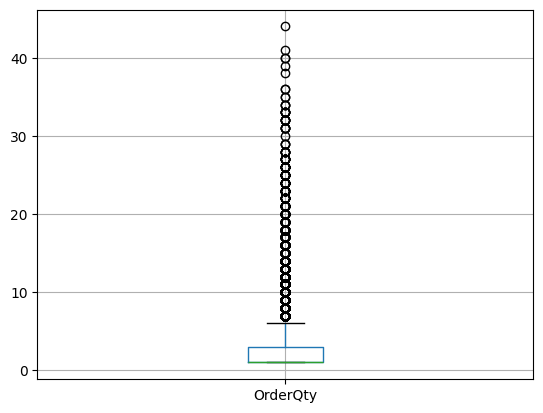

In [13]:
df.boxplot(column='OrderQty')

# 5. EDA

## 5.1 Univariate Analysis

### 5.1.1 CustomerID

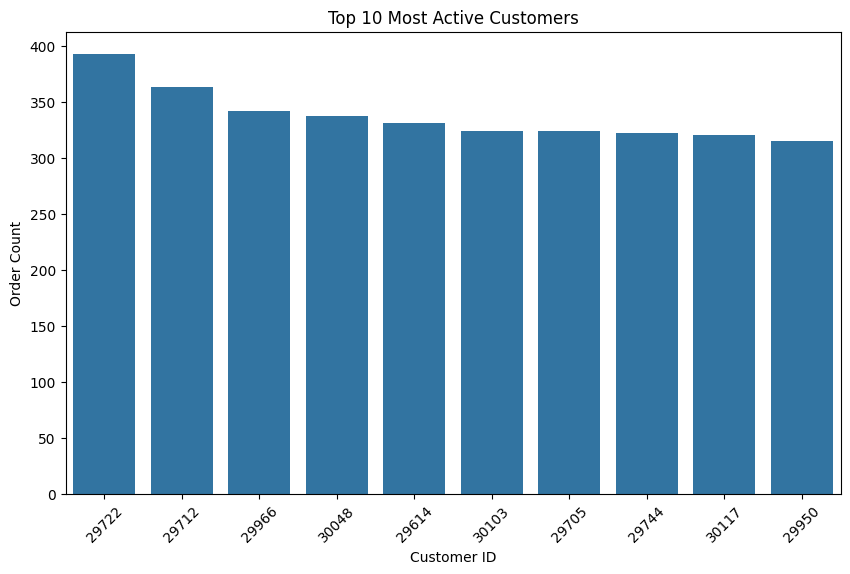

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="CustomerID", order=df["CustomerID"].value_counts().index[:10])
plt.title("Top 10 Most Active Customers")
plt.xlabel("Customer ID")
plt.ylabel("Order Count")
plt.xticks(rotation=45)
plt.show()

### 5.1.2 ProductID

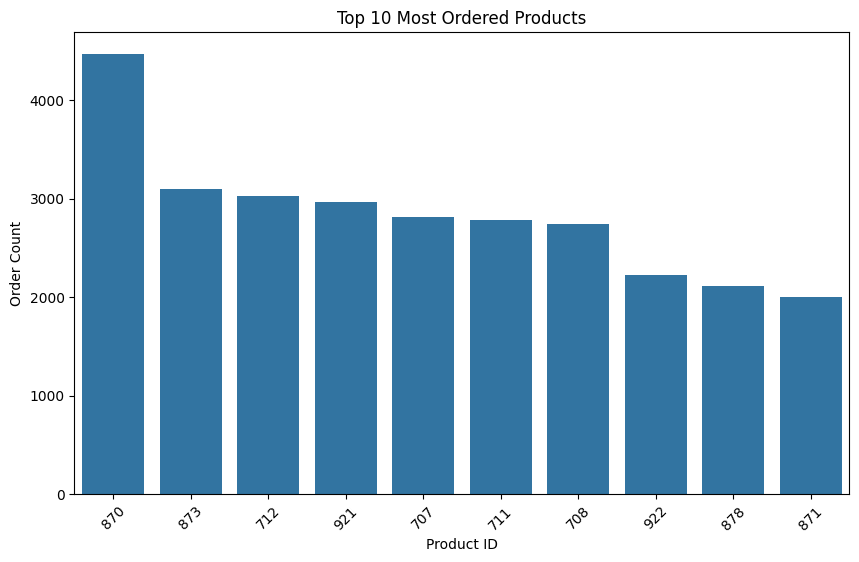

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="ProductID", order=df["ProductID"].value_counts().index[:10])
plt.title("Top 10 Most Ordered Products")
plt.xlabel("Product ID")
plt.ylabel("Order Count")
plt.xticks(rotation=45)
plt.show()

### 5.1.3 OrderQty

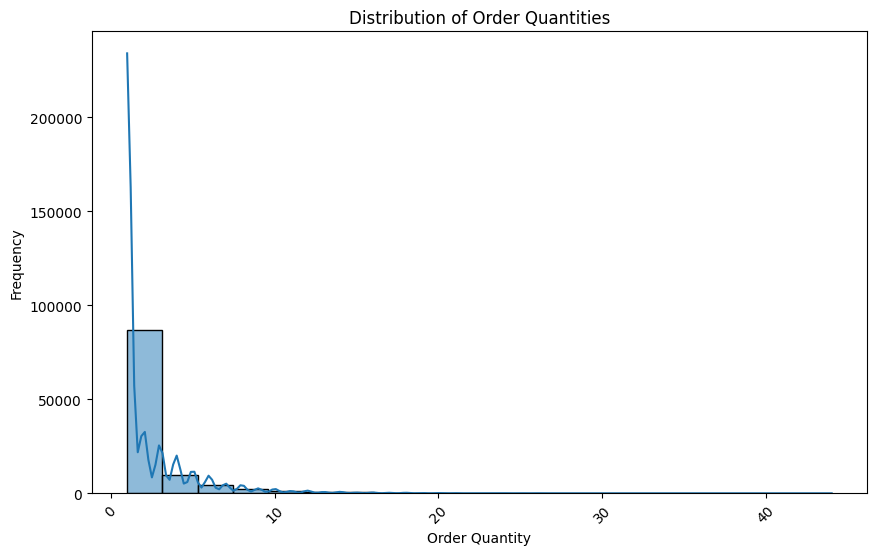

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="OrderQty", bins=20, kde=True)
plt.title("Distribution of Order Quantities")
plt.xlabel("Order Quantity")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

## 5.2 Bivariate Analysis

### 5.2.1 CustomerID vs ProductID

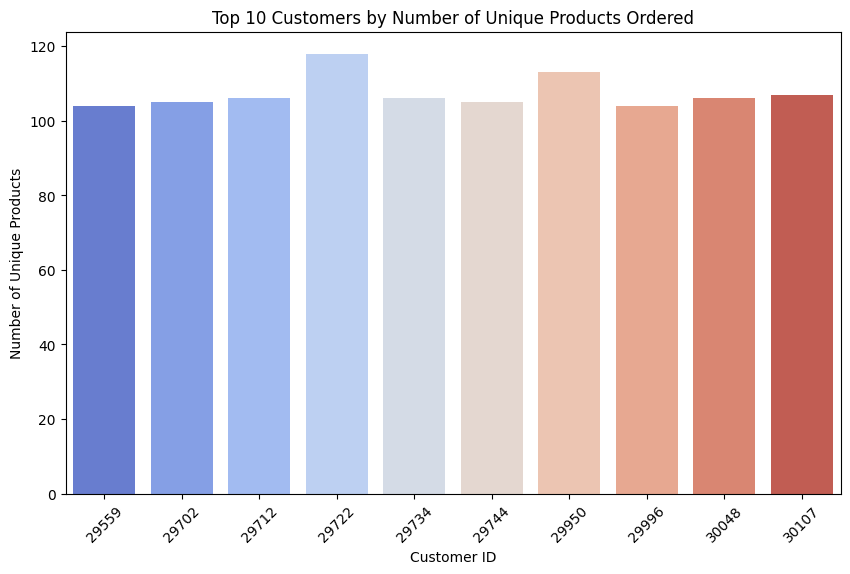

In [17]:
# Group by CustomerID and count unique ProductIDs
customer_product_counts = df.groupby("CustomerID")["ProductID"].nunique().reset_index(name="UniqueProducts")

# Sort and pick top 10 customers for better readability
top_customer_products = customer_product_counts.sort_values(by="UniqueProducts", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_customer_products, x="CustomerID", y="UniqueProducts", palette="coolwarm")
plt.title("Top 10 Customers by Number of Unique Products Ordered")
plt.xlabel("Customer ID")
plt.ylabel("Number of Unique Products")
plt.xticks(rotation=45)
plt.show()

### 5.2.2 ProductID vs OrderQty

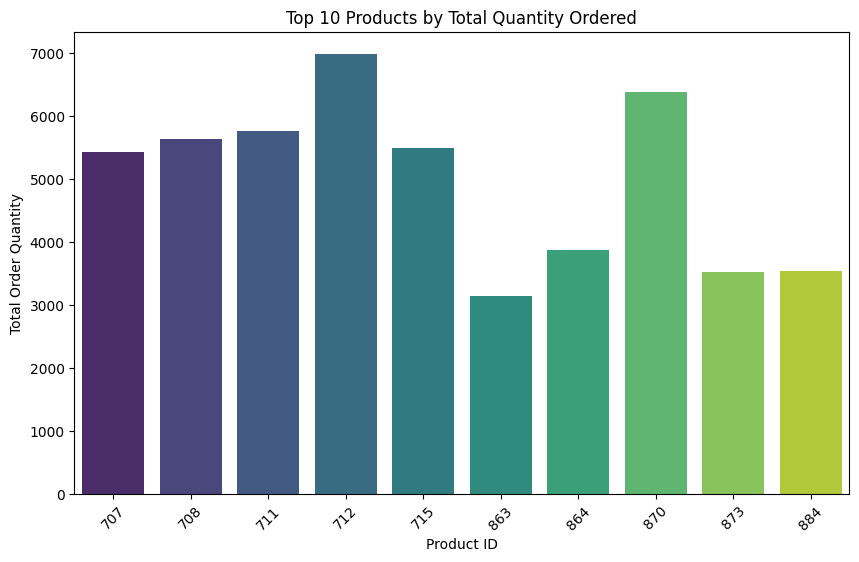

In [18]:
# Group by ProductID and sum OrderQty
product_orderqty = df.groupby("ProductID")["OrderQty"].sum().reset_index()

# Sort and pick top 10 most ordered products
top_products_qty = product_orderqty.sort_values(by="OrderQty", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_products_qty, x="ProductID", y="OrderQty", palette="viridis")
plt.title("Top 10 Products by Total Quantity Ordered")
plt.xlabel("Product ID")
plt.ylabel("Total Order Quantity")
plt.xticks(rotation=45)
plt.show()

### 5.2.3 CustomerID vs OrderQty

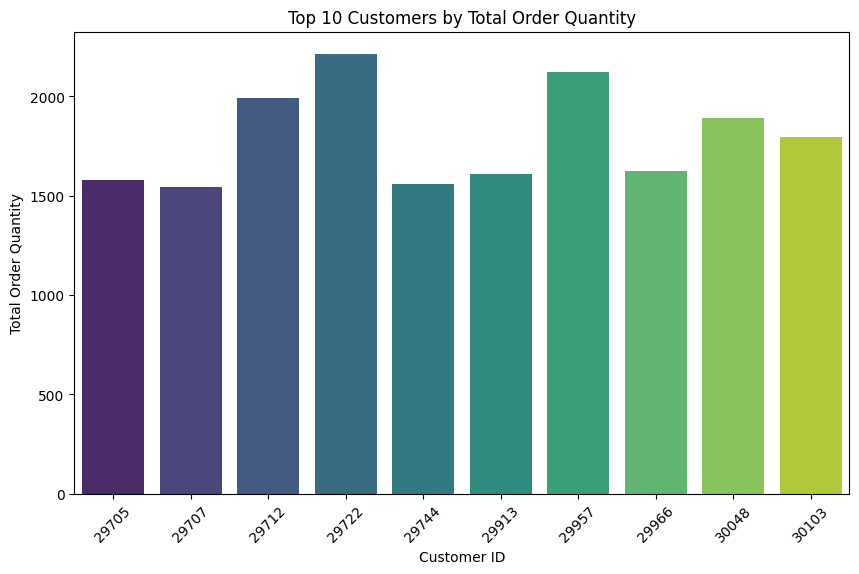

In [19]:
# Aggregate total order quantity per customer
customer_order_qty = df.groupby("CustomerID")["OrderQty"].sum().reset_index()

# Sort and select top 10 for clearer visualization
top_customers = customer_order_qty.sort_values(by="OrderQty", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_customers, x="CustomerID", y="OrderQty", palette="viridis")
plt.title("Top 10 Customers by Total Order Quantity")
plt.xlabel("Customer ID")
plt.ylabel("Total Order Quantity")
plt.xticks(rotation=45)
plt.show()

## 5.3 Multivariate Analysis

### 5.3.1 CustomerID vs ProductID vs OrderQty

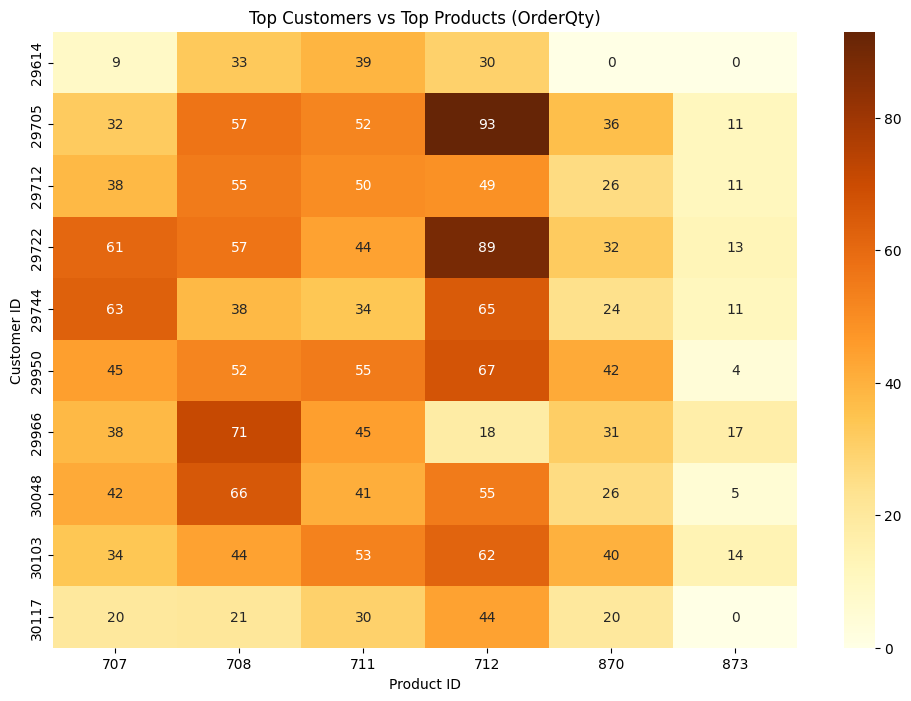

In [20]:
# Get top 10 customers and products by frequency
top_customers = df['CustomerID'].value_counts().index[:10]
top_products = df['ProductID'].value_counts().index[:10]

# Filter the DataFrame
filtered_df = df[df['CustomerID'].isin(top_customers) & df['ProductID'].isin(top_products)]

# Pivot table
pivot_table = filtered_df.pivot_table(index='CustomerID', columns='ProductID', values='OrderQty', aggfunc='sum', fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap="YlOrBr", annot=True, fmt='g')
plt.title("Top Customers vs Top Products (OrderQty)")
plt.xlabel("Product ID")
plt.ylabel("Customer ID")
plt.show()

# 6. Recommendation Methods

## 6.1. User-Based Collaborative Filtering

In [21]:
# Create user-item matrix
user_item = df.pivot_table(index='CustomerID', columns='ProductID', values='OrderQty', aggfunc='sum', fill_value=0)

# Compute similarity between customers
similarity = cosine_similarity(user_item)
similarity_df = pd.DataFrame(similarity, index=user_item.index, columns=user_item.index)

# Function: Recommend products for a given customer
def recommend_products(customer_id, top_n=5):
    if customer_id not in user_item.index:
        return f"Customer ID {customer_id} not found."

    # Get similarity scores
    similar_customers = similarity_df[customer_id].sort_values(ascending=False)[1:6]  # exclude self

    # Initialize weighted_scores as a Series
    weighted_scores = pd.Series(0, index=user_item.columns)

    for sim_cust, score in similar_customers.items():
        weighted_scores += user_item.loc[sim_cust] * score

    # Remove products already purchased by this customer
    already_bought = user_item.loc[customer_id][user_item.loc[customer_id] > 0].index
    recommendations = weighted_scores.drop(index=already_bought)

    # Return top recommended ProductIDs
    return recommendations.sort_values(ascending=False).head(top_n)

### Evaluation

In [22]:
# --- 7. Example Usage ---
customer_id = 11000  # Pick any valid customer from your data
recommendations = recommend_products(customer_id)
print(f"\nTop recommendations for Customer {customer_id}:\n", recommendations)


Top recommendations for Customer 11000:
 ProductID
782    0.801784
870    0.668153
871    0.668153
875    0.632456
708    0.000000
dtype: float64


## 6.2 KNN

In [23]:
# Fit KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_item)

# Function to recommend products using KNN
def knn_recommend_products(customer_id, top_n=5, neighbors_k=5):
    if customer_id not in user_item.index:
        return f"Customer ID {customer_id} not found."

    customer_vector = user_item.loc[customer_id].values.reshape(1, -1)
    
    distances, indices = knn.kneighbors(customer_vector, n_neighbors=neighbors_k+1)
    neighbor_ids = user_item.index[indices.flatten()[1:]]  # exclude self

    # Aggregate scores from neighbors
    weighted_scores = pd.Series(0, index=user_item.columns)
    for i, neighbor in enumerate(neighbor_ids):
        weight = 1 - distances.flatten()[i+1]  # similarity = 1 - distance
        weighted_scores += user_item.loc[neighbor] * weight

    # Remove already purchased products
    already_bought = user_item.loc[customer_id][user_item.loc[customer_id] > 0].index
    recommendations = weighted_scores.drop(index=already_bought)

    return recommendations.sort_values(ascending=False).head(top_n)

### Saving the model

In [24]:
# KNN model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_item)

# Save KNN model
joblib.dump(knn_model, 'knn_model.pkl')

['knn_model.pkl']